### The following infection data are all artificially synthesized and are only for algorithm demonstration.

In [ ]:
import pandas as pd
import numpy as np
import os
import csv
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import random 
import scipy
from scipy.stats import norm
import scipy.stats as st
np.set_printoptions(suppress=True)
import mpmath

#### Initialization

In [ ]:
# Please replace it with your local storage location.
data_path='/path/for/data/'

M_t=41*7+5#Statistical duration of mobility data.
cluster_num=5
#Mobility data
M_norm = np.loadtxt(data_path+'M_normal.txt', delimiter = ',').reshape((M_t,42,42*cluster_num))
density=np.loadtxt(data_path+'density.txt', delimiter = ',').reshape((42,42*cluster_num))#The first parameter is the number of weeks. 
dwell=np.loadtxt(data_path+'dwell.txt', delimiter = ',').reshape((42,42*cluster_num))#The second dimension is the number of UHFs multiplied by the number of place categories.
#Date-to-week index
f = open(data_path+'dict_day2week','r')
a = f.read()
day2week= eval(a)
f.close()
#Read in population data.
N_raw=pd.read_excel(data_path+'NYCpop.xlsx',usecols=['num'],dtype='int')
N_all=N_raw.values

#Set transmission parameters.
Z=3.59
D=3.56
L=180
a=0.37
b=0.04
para_num=cluster_num+2 # 5 vp for place,beta for household，error parameter for likelihood

#Delay model
aver_delay=14
x = np.arange(0.0, 21, 1) 
y1 = st.gamma.pdf(x, 1.85, scale=aver_delay/1.85)
raw=y1[1:]
prob_gamma=(raw/np.sum(raw)).reshape(20,1)

seed_0=1000#The initial total number of infections in the city.
s_factor=np.array([0.0077804 , 0.02339975, 0.03096405,0.03509373, 0.020644  ,
       0.0248404 , 0.01729817, 0.02062146, 0.02336571, 0.03521075,
       0.01557102, 0.00760455, 0.06664087, 0.03892939, 0.0254785 ,
       0.01601171, 0.03034952, 0.02062874, 0.02491628, 0.02035715,
       0.01355837, 0.02436521, 0.02877314, 0.02579249, 0.01574011,
       0.01093734, 0.02100978, 0.00591962, 0.02110973, 0.08461017,
       0.01597016, 0.00724917, 0.03076374, 0.01372457, 0.03013459,
       0.03678055, 0.02433973, 0.02106431, 0.00654353, 0.01393221,
       0.01296151, 0.02901384])
#Allocate it to UHF in a certain proportion
seed=seed_0*s_factor

#Read in the simulated infection data at the city level and the UHF level.
NYC_real_case=np.loadtxt(data_path+'/NYC_sim_obs_102.txt', delimiter = ',')
uhf_real_case=np.loadtxt(data_path+'/uhf_sim_obs_14_42.txt', delimiter = ',').reshape((14,42))
uhf_name=pd.read_excel(data_path+'uhfOrder.xlsx',usecols=['UHF_name'],dtype='str')

#Read in the simulated observation rate
sim_raw=pd.read_csv(data_path+"obs_rate_poly_uhf.csv",dtype='float')
sim_daily_rate=sim_raw.values

#Read in humidity data
humudity_raw=pd.read_csv(data_path+'NY_humudity_1.csv')
humudity=humudity_raw[56:56+M_t].values#Suppose the dissemination starts from February 26th.
R_max=2.6
R_min=1.4
hum=(np.exp(-180*humudity+np.log(R_max-R_min))+R_min)/D
hum_factor=hum/np.mean(hum)

#Read in the date list
list_path1= data_path+"date_list.txt"
date=[]
with open(list_path1, 'r') as file_l:
    for line in file_l:
       date.append(str(line.strip()))
del date[0:5]
del date[-7:]
#Read inthe week list
list_path = data_path+"week_set.txt"
week_list=[]
with open(list_path, 'r') as file_l:
    for line in file_l:
       week_list.append(str(line.strip()))

#### Functions

In [ ]:
#SEIR equation
def SEIR(currState,currM,infFor,L,Z,D,betaBase,season_factor):
    newState=np.zeros((4,42))
    newcase=np.zeros(42)
    flag=0#If out of bounds, then flag = 1.
    delta_S=currState[0]*((currM.dot(season_factor*infFor)).T)+season_factor*betaBase*currState[0]*currState[2]/(N_all.T)
    newState[0] = currState[0]-delta_S+currState[3]/L
    newState[1] = currState[1]+delta_S-currState[1]/Z
    newState[2] =currState[2]+currState[1]/Z-currState[2]/D
    newcase=currState[1]/Z
    newState[3] = currState[3]+currState[2]/D-currState[3]/L
    if np.min(newState)<0:      
        flag=1               
    return newState,newcase,flag

#Calculation of the Force of Infection (FOI)
def GetLambda(I,N,v_set,a,b,currdensity,currdwell):
    mylambda=np.zeros((42*cluster_num))
    repeat_v=np.tile(v_set,(1,42))
    partial=I/N
    mylambda=repeat_v*partial*(currdensity**a)*(currdwell**b)
    return mylambda.T

#Initial state sample generation.
def getStart(seed,factor):
    StateStart=np.zeros((4,42))
    for i in range(42):
        s=seed[i]
        StateStart[2][i]=random.uniform(max(s-15,1),s+15)#Inflation on seeds
        StateStart[1][i]=factor*StateStart[2][i]
        StateStart[3][i]=0
        StateStart[0][i]=N_all[i]-StateStart[1][i]-StateStart[2][i]-StateStart[3][i]
    return  StateStart 

#Function for simulating the scale of transmission
def simulation(para,t1,t2,wnum,uhf_start,statestart,startcase):
    State=np.zeros((t2-t1+1,4,42))
    State[0]=statestart
    v_set=para[0:5]
    beta=para[5]
    valid_sim=0
    uhf_daily_obs=np.zeros(((t2-t1,42)))
    uhf_week_obs=np.zeros(((wnum,42)))
    new_case=startcase.copy()
    for t in range(1,t2-t1+1):
        if valid_sim ==0 :
            real_t=t1+t
            deltacase=np.zeros(42)
            I_set=State[t-1][2].dot(M_norm[real_t-1])
            N_set=(N_all.T).dot(M_norm[real_t-1])
            infFor=GetLambda(I_set,N_set,v_set,a,b,density[day2week[real_t-1]],dwell[day2week[real_t-1]])#FOI
            State[t],deltacase,flag=SEIR(State[t-1],M_norm[real_t-1],infFor,L,Z,D,beta,hum_factor[real_t-1])
            if flag==0:
                deltacase=deltacase.reshape(1,42)
                prob_case=prob_gamma.dot(deltacase)
                new_case[real_t:min(real_t+20,M_t)]+=prob_case[:min(M_t-real_t,20)]
            else:
                valid_sim=1
    uhf_daily_obs=sim_daily_rate[t1:t2]*new_case[t1:t2]
    sum_daily_obs=np.sum(uhf_daily_obs,axis=1)#NYC_daily observations
    uhf_week_obs=np.sum(uhf_daily_obs[uhf_start:uhf_start+7*wnum].reshape((wnum,7,42)),axis=1)#We assume that the weekly report data of UHF appears on the 4th day.
    return valid_sim,uhf_week_obs,sum_daily_obs,State[-1],new_case

#Calculate log likelihood
def GetUHFLogLikelihood(real_uhf,uhf_obs,err_para):
    loguhflikelihood=0
    likelihood=scipy.stats.norm.pdf(real_uhf,loc=uhf_obs,scale=20+err_para*uhf_obs)
    likelihood[likelihood==0]=0.00001
    loguhflikelihood=np.sum(np.log(likelihood))           
    return loguhflikelihood

#Metropolis-Hastings algorithm
def MH_step(para_index,step,para_set,curr_real_case,p_scale,weeknum,t1,t2,uhf_start,statestart,casestart,reject_factor):
    prior_p=para_set[para_index]
    pos_uhf_case=np.zeros((weeknum,42))
    pri_uhf_case=np.zeros((weeknum,42))
    pri_cell=simulation(para_set,t1,t2,weeknum,uhf_start,statestart,casestart)
    pri_uhf_case=pri_cell[1]
    pri_log_prob=GetUHFLogLikelihood(curr_real_case,pri_uhf_case,para_set[-1])
    new_para_set=para_set.copy()
    repeat_num=0
    choice_flag=0
    while True:
        repeat_num+=1
        if repeat_num<100:
            post_p=np.random.normal(loc=prior_p,scale=step)
            if post_p >p_scale[0] and post_p < p_scale[1]:
                new_para_set[para_index]=post_p
                if para_index !=para_num-1:
                    iter_cell=simulation(new_para_set,t1,t2,weeknum,uhf_start,statestart,casestart)
                    if iter_cell[0]==0:
                        pos_uhf_case=iter_cell[1]
                        pos_log_prob=GetUHFLogLikelihood(curr_real_case,pos_uhf_case,new_para_set[-1])
                        break 
                else:
                    #Adjust the error parameters of likelihood. There is no need to re-simulate the infection situation. Directly calculate the posterior likelihood.
                    pos_log_prob=GetUHFLogLikelihood(curr_real_case,pri_uhf_case,new_para_set[-1])
                    break
        else:
            choice_flag=1
            break
    if choice_flag==0:
        u=mpmath.exp(pos_log_prob-pri_log_prob)
        if u>1 or np.random.uniform(0,1)<reject_factor*u:
            return post_p,1
        else:
            return prior_p,0
    else:
        print('Currently, there are no suitable posterior parameters, and the adaptation fails')
        return prior_p,2
    
def getMCMC(para_start,para_step,weekstart,weeknum,t1,t2,uhf_start,statestart,casestart,para_scale,rej_fac,n_mcmc,sam_num,trace_step):
    para_record=np.zeros((n_mcmc+1,para_num))
    para_record[0]=para_start
    stady_set=np.zeros((sam_num,para_num))
    recept_flag=0
    recept_record=np.zeros(n_mcmc+1)
    valid_flag=1
    for i in range(n_mcmc):
        para_record[i+1]=para_record[i]
        if valid_flag==1:
            for j in range(para_num):# For each parameter, perform a perturbation.
                para_record[i+1][j],recept_flag=MH_step(j,para_step[j],para_record[i+1],uhf_real_case[weekstart:weekstart+weeknum],para_scale[j],weeknum,t1,t2,uhf_start,statestart,casestart,rej_fac)
                if recept_flag==2:
                    valid_flag=0
                    break
                else: 
                    recept_record[i+1]=recept_record[i]+recept_flag
        else:
            break

    if valid_flag==1:#Sampling
        stady_set=np.array([para_record[trace_step*k1-sam_num*trace_step] for k1 in range(sam_num)])
        cont_sam=para_record[-int(0.95*n_mcmc):]

    #To get the parameter with the smallest error.
    error_set=np.zeros(sam_num)
    uhfState_set=np.zeros((sam_num,4,42))
    case_set=np.zeros((sam_num,M_t,42))
    for i in range(sam_num):
        uhf_obs,_,uhfState_set[i],case_set[i]=simulation(stady_set[i],t1,t2,weeknum,uhf_start,statestart,casestart)[1:]
        error_set[i]=np.mean(abs(uhf_real_case[weekstart:weekstart+weeknum]-uhf_obs))
    best_sample_id=np.argmin(error_set)
    para_new=stady_set[best_sample_id]
    best_sample_endstate=uhfState_set[best_sample_id]
    best_sample_case=case_set[best_sample_id]
    return para_new,stady_set,best_sample_endstate,best_sample_case,cont_sam

#### Main

In [ ]:
n1=1000000#Number of training iterations of the Metropolis-Hastings algorithm
trace_step=95#Sampling interval
EIfactor=5#The ratio between E and I
sam_num=10000#Number of samples

#Upper and lower limits of parameters
vp_u=100;vp_l=0
beta_u=0.2;beta_l=0.0001
err_para_u=1;err_para_l=0.1
para_scale0=np.zeros((para_num, 2))#For easy passing in.
para_scale0[:5]=[vp_l,vp_u]
para_scale0[5]=[beta_l,beta_u]
para_scale0[6]=[err_para_l,err_para_u]

#Initial state setting.
para_0=np.array([1,1 ,1 ,1 ,1, 0.01,0.5])
para_step=np.array([5,5 ,10 ,15 ,5, 0.02,0.1])
state0=getStart(seed,EIfactor)
case0=np.zeros((M_t,42)) 

End_t=103#Suppose it ends on June 8th.
best_para,para_set,_,_,cont_sample=getMCMC(para_0,para_step,0,14,1,End_t,4,state0,case0,para_scale0,0.3,n1,sam_num,trace_step)#uhf_start=4,We assume that the weekly report data of UHF appears on the 4th day, that is, 2020 March 1st.

#### Plot

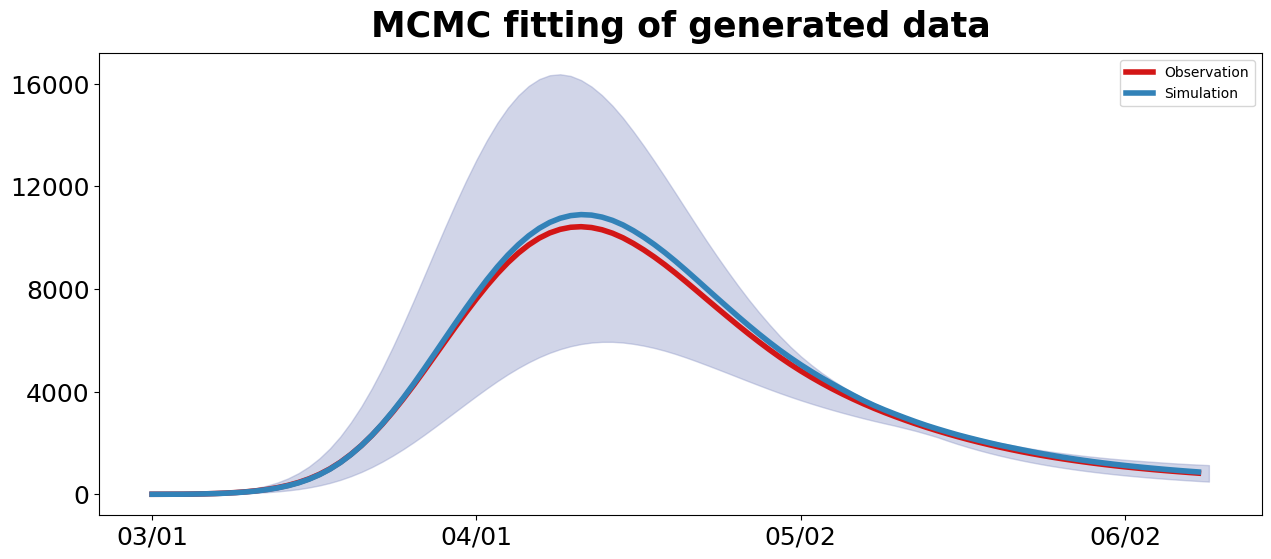

In [ ]:
def seed_sample(seed,factor):#Perturbation generates the initial state.
    StateStart=np.zeros((4,42))
    for i in range(42):
        s=seed[i]
        StateStart[2][i]=random.uniform(0.5*s,1.5*s)
        StateStart[1][i]=factor*StateStart[2][i]
        StateStart[3][i]=0
        StateStart[0][i]=N_all[i]-StateStart[1][i]-StateStart[2][i]-StateStart[3][i]
    return  StateStart 

free_num=500#Number of simulation samples.
case_record=np.zeros((free_num,End_t))
uhf_record=np.zeros((free_num,14,42))
for i in range(free_num):
    State0=np.zeros((4,42))
    seed_sim=random.uniform(500,2000)*s_factor#The current seed range can be artificially adjusted to adapt to different infection data.
    State0=seed_sample(seed_sim,random.uniform(2,6))#The current E and I can be artificially adjusted to adapt to different disease data.
    result=simulation(best_para,0,End_t,14,4,State0,case0)
    case_record[i]=result[2]
    uhf_record[i]=result[1]
   
NYC_median=np.median(case_record,axis=0)

#Draw the fitting interval and the mean curve.
hex_colors=['#D31616','#3282B8','#F6C90E','#137C00','#8c96c6']
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(date[1:len(NYC_median)-1],NYC_real_case[1:],color=hex_colors[0], linewidth=4)
ax.plot(date[1:len(NYC_median)-1], NYC_median[1:-1],color=hex_colors[1], linewidth=4)
lower=np.array([np.percentile(case_record[:,i+1], 2.5) for i in range(len(NYC_median[1:]-1))])
upper=np.array([np.percentile(case_record[:,i+1], 97.5) for i in range(len(NYC_median[1:]-1))])
plt.fill_between(date[1:len(NYC_median)],lower, upper, interpolate=True, color=hex_colors[4], alpha=0.4)

#Coordinate setting.
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(31))
plt.setp(plt.gca().get_xticklabels(),rotation=0)
plt.legend(labels=['Observation','Simulation'] )
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(4000))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('MCMC fitting of generated data',loc='center', fontweight='bold', pad=12, fontsize=25)
plt.show()

#### Fitting situation of 42 UHFs.

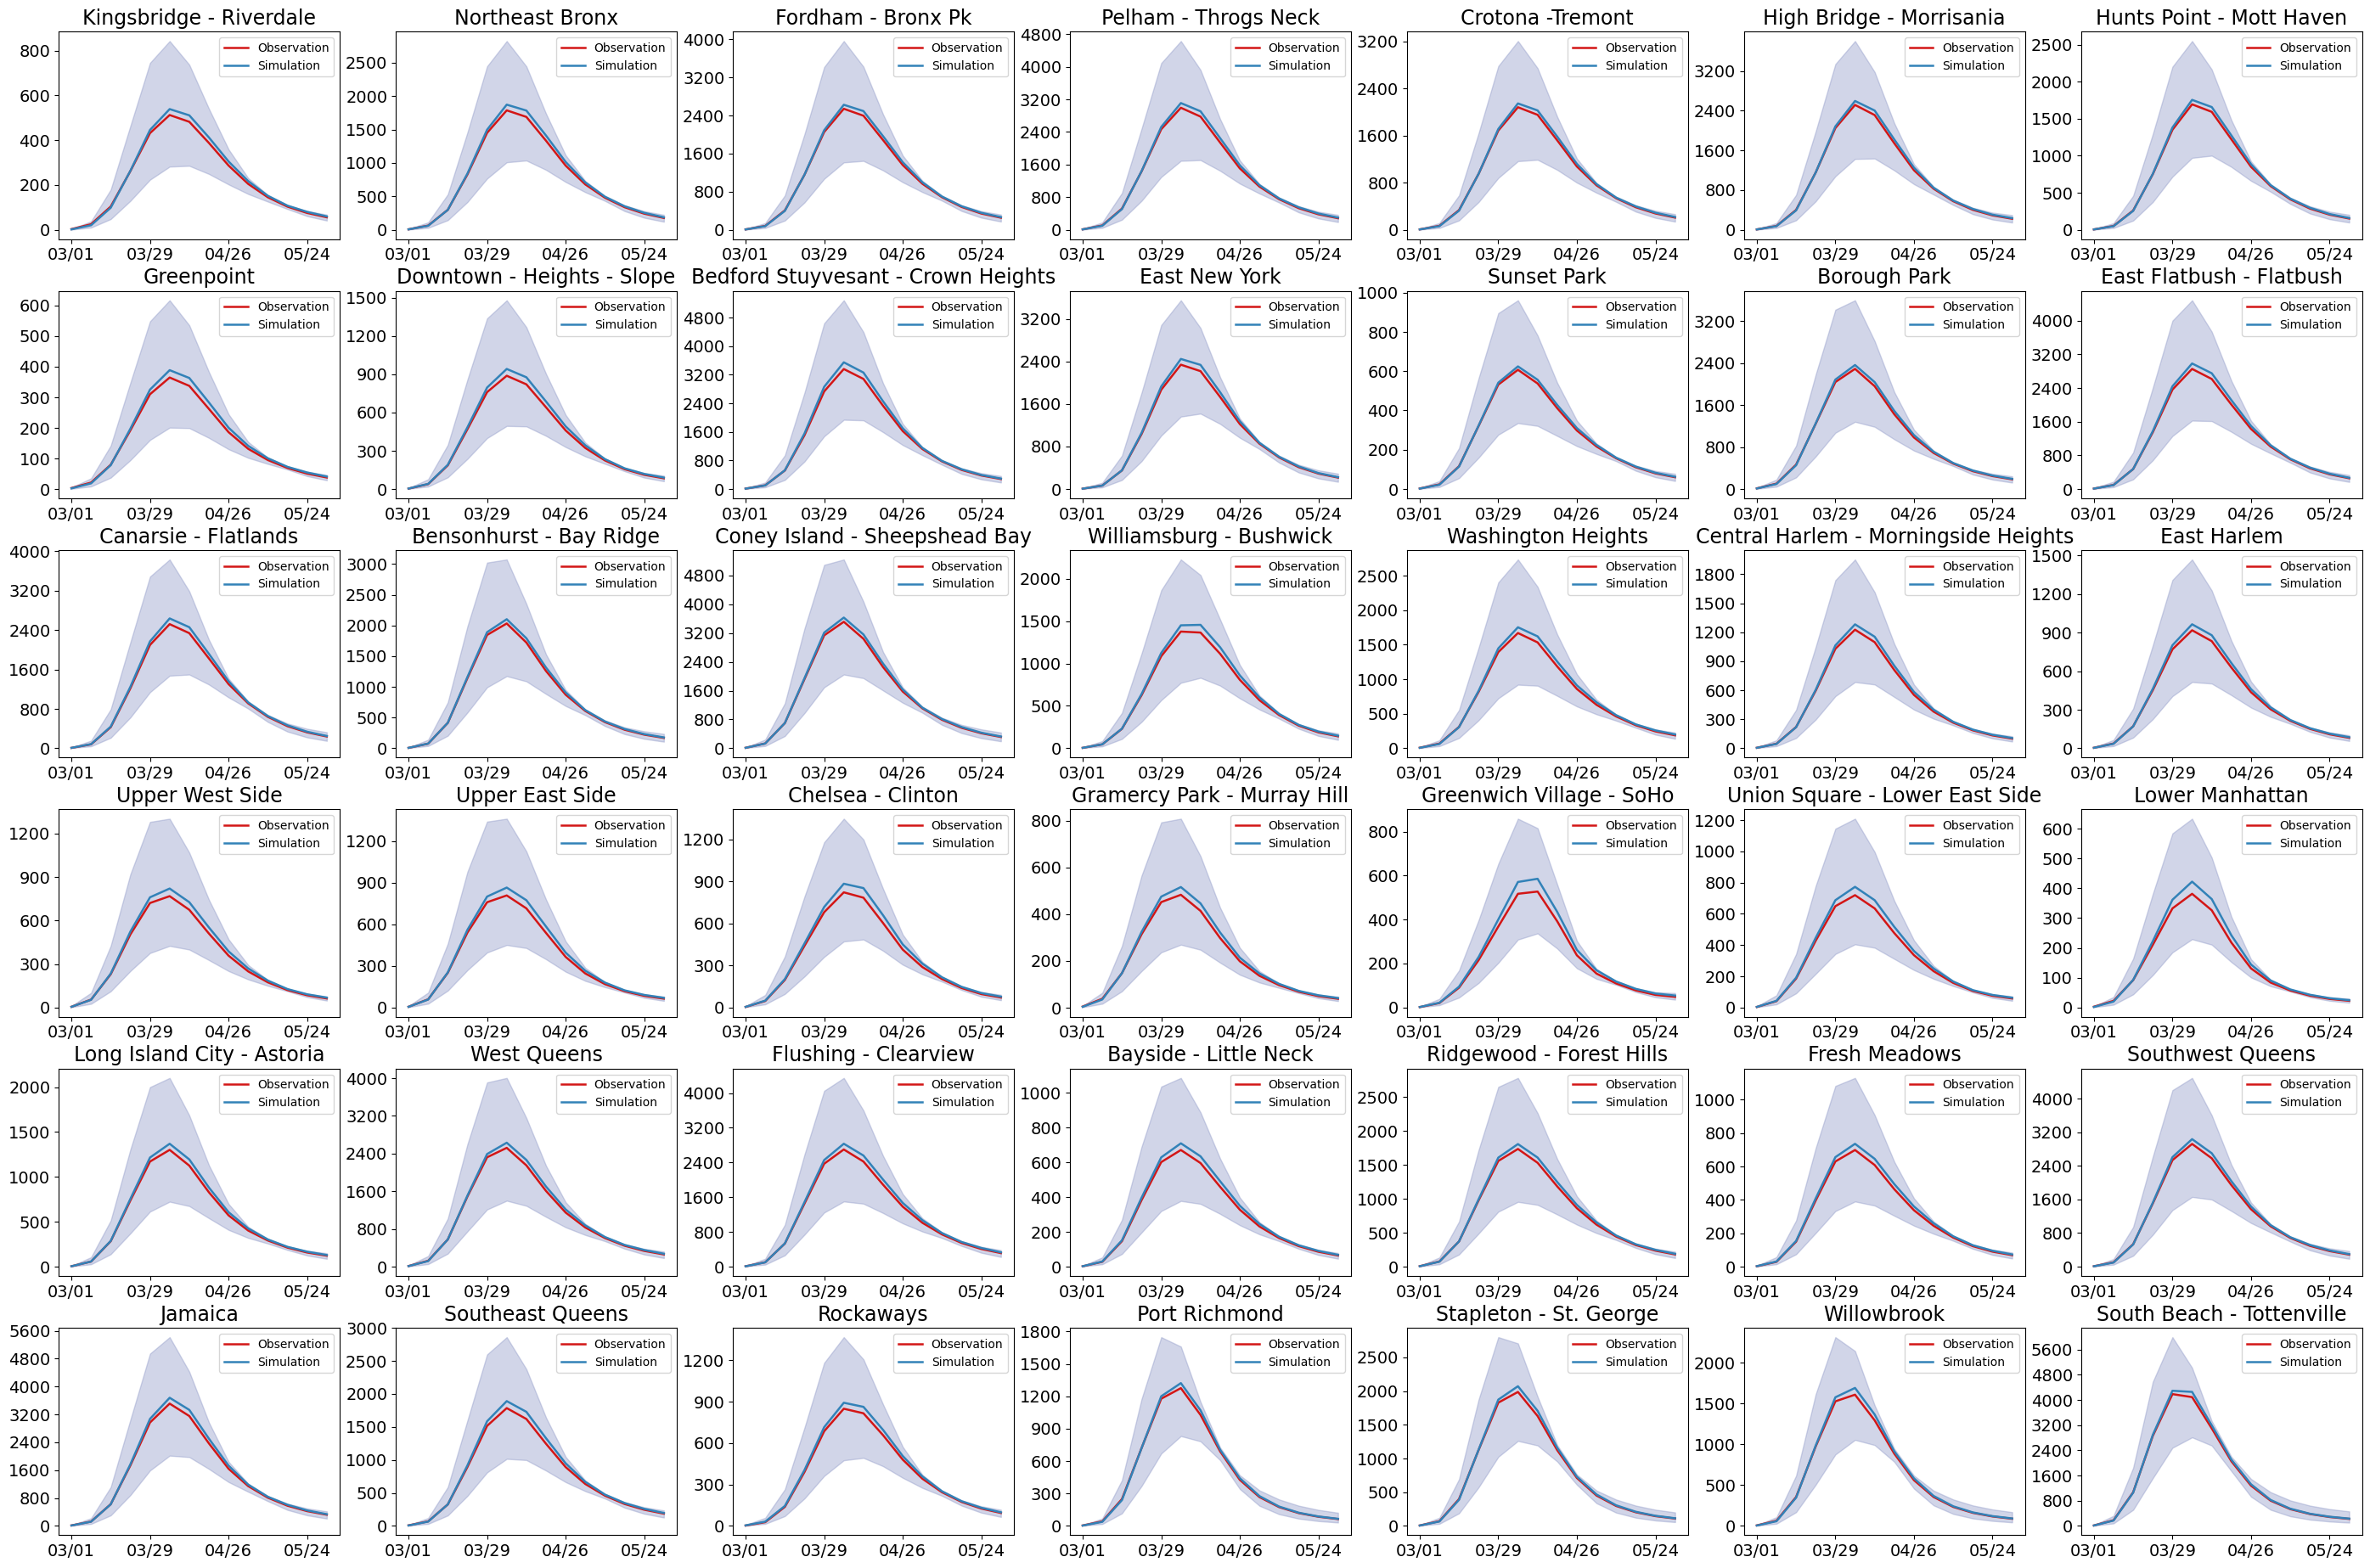

In [ ]:
hex_colors= np.array([(211,22,22),
          (50,130,184), 
        (246,201,14),
          (140,150,198)])/255

uhf_name=pd.read_excel(data_path+'uhfOrder.xlsx',usecols=['UHF_name'],dtype='str')
fig=plt.figure(figsize=(35,23)) 


for j in range(42):
    ax=plt.subplot(6,7,j+1)
    ax.plot(week_list[:14],uhf_real_case[:14,j],color=hex_colors[0], linewidth=1.8) 
    plt.title(uhf_name['UHF_name'][j],fontsize=17)
    uhf_median=np.median(uhf_record[:,:,j],axis=0)
    ax.plot(week_list[:14], uhf_median,color=hex_colors[1], linewidth=1.8)

    lower=np.array([np.percentile(uhf_record[:,i,j], 2.5) for i in range(len(uhf_median))])
    upper=np.array([np.percentile(uhf_record[:,i,j], 97.5) for i in range(len(uhf_median))])
    plt.legend(labels=['Observation','Simulation'] )
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(8))
    plt.fill_between(week_list[:14],lower, upper, interpolate=True, color=hex_colors[3], alpha=0.4)
    
    #Set an appropriate vertical coordinate
    max_y=max(np.max(uhf_real_case[:,j]),np.max(upper))
    if max_y>1250 and max_y<2100:
        delta_y=300
    if max_y>2100 and max_y<3200:
        delta_y=500
    if max_y>650 and max_y<1250:
        delta_y=200
    if max_y<650:
        delta_y=100
    if max_y>3200 :
        delta_y=800
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(4))
    plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(delta_y))
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.subplots_adjust(hspace=0.25,wspace=0.2)
plt.show()